### Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
import math
import time
from collections import deque
%config InlineBackend.figure_format='svg'

### Data (strings) and splitting

In [2]:
fname = "DATA/sequences16.csv"
sx ,sy = np.loadtxt(fname,delimiter=',',
                   usecols=(0,1),unpack=True,dtype=str)
N = len(sy)
print(N)
Ls = len(sx[0])
print(Ls)

print(sx[0],sy[0])
perc_train = .8
N_train = int(N*perc_train)
N_test = N - N_train
print(f'\ndata: {N} \ntrain: {N_train} \ntest: {N_test} ')

3000
16
AAGGTCTGCCGGCCGA 1

data: 3000 
train: 2400 
test: 600 


### Augmentation

In [3]:
def Augmetation(s,y):
    Ls = len(s)
    M = np.ndarray((Ls-1),dtype='<U16')
    M[0] = s[-1:]+s[:-1]
    for i in range(1,Ls-1):
        M[i] = M[i-1][-1:]+M[i-1][:-1]
    return M, np.full(Ls-1,y)

In [4]:
def Augmentation2(s,y):
    Ls = int(len(s)/4)
    M = np.zeros((Ls-1,Ls*4))
    a = deque(s.tolist())
    a.rotate(4)
    M[0] = a
    for i in range(1,Ls-1):
        a = deque(M[i-1].tolist())
        a.rotate(4)
        M[i] = a
    return M, np.full(Ls-1,y)


In [5]:
# We map the characters in 0:3 to make the input readable for NN one hot encoding
Q = ['A','C','G','T']
Nc = len(Q)
onehc = {Q[i]:i for i in range(Nc)}
print(onehc)


{'A': 0, 'C': 1, 'G': 2, 'T': 3}


### Data conversion

In [6]:
y = sy.astype(int)

L = Ls*Nc
print(L)

x = np.zeros((N,L))
for n in range(N):
    for i in range(Ls):
        x[n][i*4+onehc[sx[n][i]]] = 1
print(sx[1])
print(x[1])

64
CCTCCCTTATGGGGGA
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.]


### Split train/test-validation

In [7]:
(x_train,y_train) = (x[:N_train],y[:N_train])
(x_test,y_test) = (x[N_train:],y[N_train:])


print(y_train.sum()/N_train)
print(y_test.sum()/N_test)
# They are similar so we are ok

0.24333333333333335
0.25833333333333336


### Definition of the model in keras

In [8]:
np.random.seed(123)

model = Sequential()

model.add(Dense(L, input_shape = (L,), activation = "relu"))
model.add(Dense(int(L/2), activation = "relu"))
model.add(Dense(int(L/4), activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))

print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

fit = model.fit(x_train,y_train,
               epochs=100,batch_size=50,
               validation_data=(x_test,y_test),
               shuffle=True # change composition of minibatch
               )

Epoch 1/100
48/48 [==============================] - 2s 22ms/step - loss: 0.6500 - accuracy: 0.5985 - val_loss: 0.5653 - val_accuracy: 0.7417
Epoch 2/100
48/48 [==============================] - 0s 2ms/step - loss: 0.5194 - accuracy: 0.7587 - val_loss: 0.5330 - val_accuracy: 0.7417
Epoch 3/100
48/48 [==============================] - 0s 3ms/step - loss: 0.4846 - accuracy: 0.7742 - val_loss: 0.5157 - val_accuracy: 0.7433
Epoch 4/100
48/48 [==============================] - 0s 3ms/step - loss: 0.4794 - accuracy: 0.7622 - val_loss: 0.4991 - val_accuracy: 0.7467
Epoch 5/100
48/48 [==============================] - 0s 3ms/step - loss: 0.4428 - accuracy: 0.7877 - val_loss: 0.4940 - val_accuracy: 0.7517
Epoch 6/100
48/48 [==============================] - 0s 3ms/step - loss: 0.4134 - accuracy: 0.8067 - val_loss: 0.4928 - val_accuracy: 0.7483
Epoch 7/100
48/48 [==============================] - 0s 2ms/step - loss: 0.4106 - accuracy: 0.8075 - val_loss: 0.4886 - val_accuracy: 0.7550
Epoch 8/100


Epoch 59/100
48/48 [==============================] - 0s 2ms/step - loss: 6.9331e-04 - accuracy: 1.0000 - val_loss: 1.2802 - val_accuracy: 0.8117
Epoch 60/100
48/48 [==============================] - 0s 2ms/step - loss: 6.9985e-04 - accuracy: 1.0000 - val_loss: 1.2889 - val_accuracy: 0.8150
Epoch 61/100
48/48 [==============================] - 0s 2ms/step - loss: 7.1067e-04 - accuracy: 1.0000 - val_loss: 1.3204 - val_accuracy: 0.8117
Epoch 62/100
48/48 [==============================] - 0s 2ms/step - loss: 8.6923e-04 - accuracy: 1.0000 - val_loss: 1.3178 - val_accuracy: 0.8150
Epoch 63/100
48/48 [==============================] - 0s 2ms/step - loss: 6.4907e-04 - accuracy: 1.0000 - val_loss: 1.3489 - val_accuracy: 0.8167
Epoch 64/100
48/48 [==============================] - 0s 2ms/step - loss: 5.8138e-04 - accuracy: 1.0000 - val_loss: 1.3420 - val_accuracy: 0.8183
Epoch 65/100
48/48 [==============================] - 0s 2ms/step - loss: 4.8263e-04 - accuracy: 1.0000 - val_loss: 1.3663 -

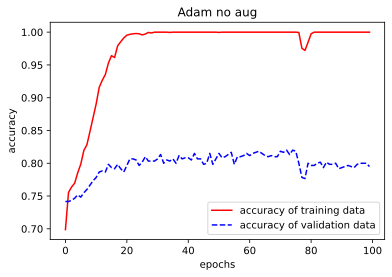

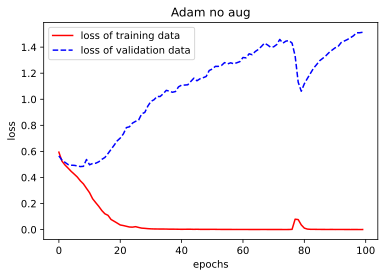

In [10]:
for obs in ('accuracy', 'loss'):
    plt.figure(figsize = (6,4))
    plt.plot(fit.history[obs], 'r', label = obs +' of training data')
    
    plt.plot(fit.history['val_' + obs], 'b--', label = obs + ' of validation data')
    plt.title('Adam no aug')
    plt.ylabel(obs)
    plt.xlabel('epochs')
    plt.legend()
    plt.show()


In [11]:
np.random.seed(123)

model1 = Sequential()

# We make the input layer w/ L samples
model1.add(Dense(L,input_shape=(L,),activation="relu"))

# Second layer
model1.add(Dense(int(L/2),activation="relu"))

# Third layer
model1.add(Dense(int(L/4),activation="relu"))

# add Dropout in the last layer
model1.add(Dropout(0.2))

# Output layer
model1.add(Dense(1,activation="sigmoid"))


print(model1.summary())
opt1=SGD(learning_rate=0.01,
        momentum = 0.9, #if = 0 is vanilla
        nesterov = True)

model1.compile(loss = 'binary_crossentropy', #1 or 0 with log scale
              optimizer = opt1,
              metrics = ['accuracy'])
fit1 = model1.fit(x_train,y_train,
               epochs=100,batch_size=50,
               validation_data=(x_test,y_test),
               shuffle=True # change composition of minibatch
               )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
48/48 [==============================] - 1s 5ms/step - loss: 0.5918 - accuracy: 0.7447 - val_loss: 0.

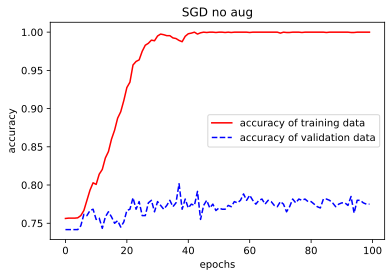

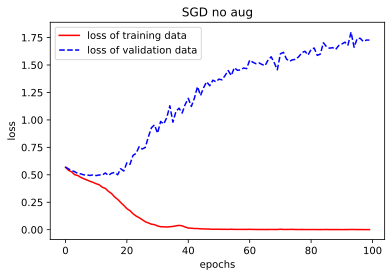

In [12]:
for obs in ('accuracy', 'loss'):
    plt.figure(figsize = (6,4))
    plt.plot(fit1.history[obs], 'r', label = obs +' of training data')
    
    plt.plot(fit1.history['val_' + obs], 'b--', label = obs + ' of validation data')
    plt.title('SGD no aug')
    plt.ylabel(obs)
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

### Augmentated data

In [13]:
# We stock the data augmentated in another array, so we can do some analysis
x_trainaug = np.zeros((N_train,L))
y_trainaug = np.zeros(N_train)
x_trainaug[:] = x_train[:]
y_trainaug[:] = y_train[:]

print(x_trainaug.shape)

for i in range(N_train):
    f = Augmentation2(x_train[i],y_train[i])
    x_trainaug = np.append(x_trainaug,f[0], axis=0)
    y_trainaug = np.append(y_trainaug,f[1]) 
    
print(x_trainaug.shape)

(2400, 64)
(38400, 64)


In [14]:
np.random.seed(123)

modelaug = Sequential()

modelaug.add(Dense(L, input_shape = (L,), activation = "relu"))
modelaug.add(Dense(int(L/2), activation = "relu"))
modelaug.add(Dense(int(L/4), activation = "relu"))
modelaug.add(Dropout(0.2))
modelaug.add(Dense(1, activation = "sigmoid"))

print(modelaug.summary())
modelaug.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])
fitaug = modelaug.fit(x_trainaug,y_trainaug,
               epochs=100,batch_size=50,
               validation_data=(x_test,y_test),
               shuffle=True # change composition of minibatch
               )



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
768/768 [==============================] - 1s 1ms/step - loss: 0.5381 - accuracy: 0.7406 - val_loss: 

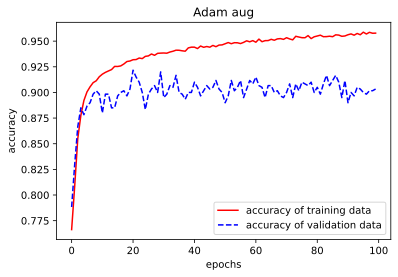

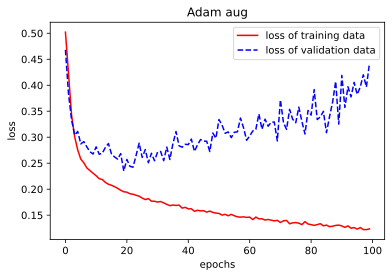

In [15]:
for obs in ('accuracy', 'loss'):
    plt.figure(figsize = (6,4))
    plt.plot(fitaug.history[obs], 'r', label = obs +' of training data')
    
    plt.plot(fitaug.history['val_' + obs], 'b--', label = obs + ' of validation data')
    plt.title('Adam aug')
    plt.ylabel(obs)
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

In [16]:
np.random.seed(123)

model1aug = Sequential()
# We make the input layer w/ L samples
model1aug.add(Dense(L,input_shape=(L,),activation="relu"))
# Second layer
model1aug.add(Dense(int(L/2),activation="relu"))
# Third layer
model1aug.add(Dense(int(L/4),activation="relu"))
# add Dropout in the last layer
model1aug.add(Dropout(0.2))
# Output layer
model1aug.add(Dense(1,activation="sigmoid"))
print(model1aug.summary())

model1aug.compile(loss = 'binary_crossentropy', #1 or 0 with log scale
              optimizer = opt1,
              metrics = ['accuracy'])
fit1aug = model1aug.fit(x_trainaug,y_trainaug,
               epochs=100,batch_size=50,
               validation_data=(x_test,y_test),
               shuffle=True # change composition of minibatch
               )


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
768/768 [==============================] - 1s 1ms/step - loss: 0.5439 - accuracy: 0.7474 - val_loss: 

Epoch 51/100
768/768 [==============================] - 1s 1ms/step - loss: 0.1609 - accuracy: 0.9446 - val_loss: 0.2677 - val_accuracy: 0.9100
Epoch 52/100
768/768 [==============================] - 1s 1ms/step - loss: 0.1588 - accuracy: 0.9459 - val_loss: 0.2850 - val_accuracy: 0.9150
Epoch 53/100
768/768 [==============================] - 1s 1ms/step - loss: 0.1447 - accuracy: 0.9515 - val_loss: 0.2663 - val_accuracy: 0.9150
Epoch 54/100
768/768 [==============================] - 1s 1ms/step - loss: 0.1536 - accuracy: 0.9476 - val_loss: 0.2640 - val_accuracy: 0.9067
Epoch 55/100
768/768 [==============================] - 1s 1ms/step - loss: 0.1546 - accuracy: 0.9480 - val_loss: 0.2718 - val_accuracy: 0.9150
Epoch 56/100
768/768 [==============================] - 1s 1ms/step - loss: 0.1512 - accuracy: 0.9495 - val_loss: 0.2913 - val_accuracy: 0.9150
Epoch 57/100
768/768 [==============================] - 1s 1ms/step - loss: 0.1479 - accuracy: 0.9507 - val_loss: 0.2620 - val_accuracy:

### Plots

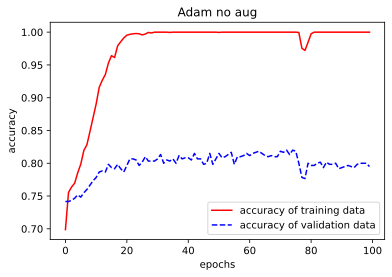

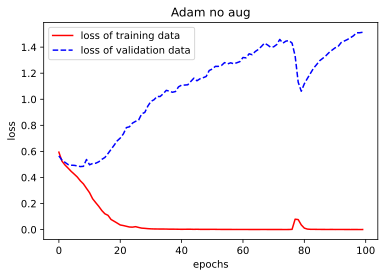

In [17]:
for obs in ('accuracy', 'loss'):
    plt.figure(figsize = (6,4))
    plt.plot(fit.history[obs], 'r', label = obs +' of training data')
    
    plt.plot(fit.history['val_' + obs], 'b--', label = obs + ' of validation data')
    plt.title('Adam no aug')
    plt.ylabel(obs)
    plt.xlabel('epochs')
    plt.legend()
    plt.show()


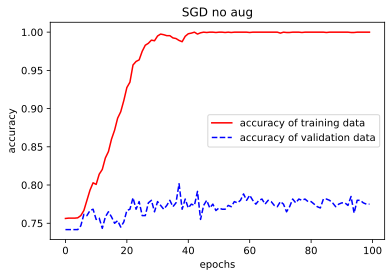

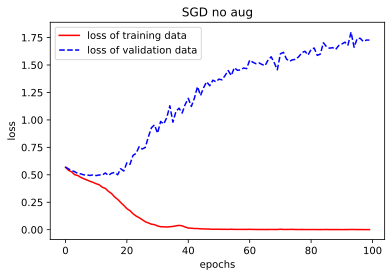

In [18]:
for obs in ('accuracy', 'loss'):
    plt.figure(figsize = (6,4))
    plt.plot(fit1.history[obs], 'r', label = obs +' of training data')
    
    plt.plot(fit1.history['val_' + obs], 'b--', label = obs + ' of validation data')
    plt.title('SGD no aug')
    plt.ylabel(obs)
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

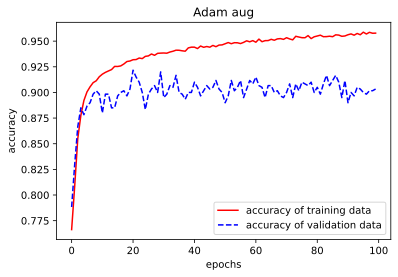

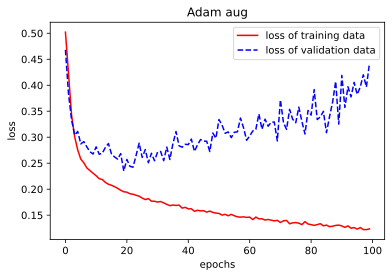

In [19]:

for obs in ('accuracy', 'loss'):
    plt.figure(figsize = (6,4))
    plt.plot(fitaug.history[obs], 'r', label = obs +' of training data')
    
    plt.plot(fitaug.history['val_' + obs], 'b--', label = obs + ' of validation data')
    plt.title('Adam aug')
    plt.ylabel(obs)
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

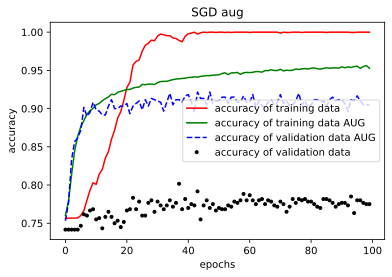

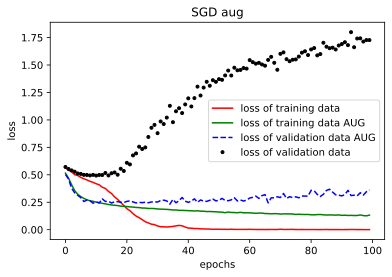

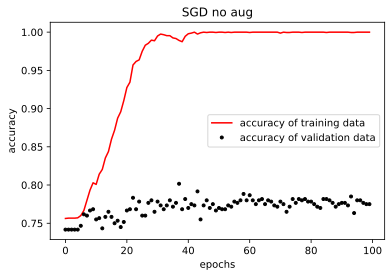

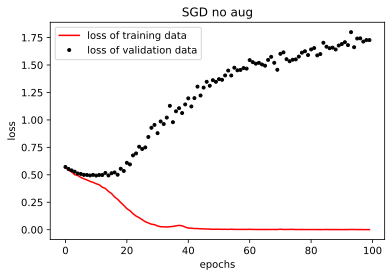

In [20]:
for obs in ('accuracy', 'loss'):
    plt.figure(figsize = (6,4))
    plt.plot(fit1.history[obs], 'r', label = obs +' of training data')
    plt.plot(fit1aug.history[obs], 'g', label = obs +' of training data AUG')
    
    plt.plot(fit1aug.history['val_' + obs], 'b--', label = obs + ' of validation data AUG')
    plt.plot(fit1.history['val_' + obs], '.k', label = obs + ' of validation data')
    plt.title('SGD aug')
    plt.ylabel(obs)
    plt.xlabel('epochs')
    plt.legend()
    plt.show()
for obs in ('accuracy', 'loss'):
    plt.figure(figsize = (6,4))
    plt.plot(fit1.history[obs], 'r', label = obs +' of training data')
    
    plt.plot(fit1.history['val_' + obs], '.k', label = obs + ' of validation data')
    plt.title('SGD no aug')
    plt.ylabel(obs)
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

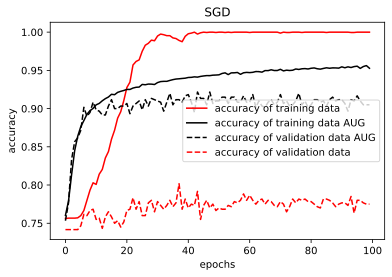

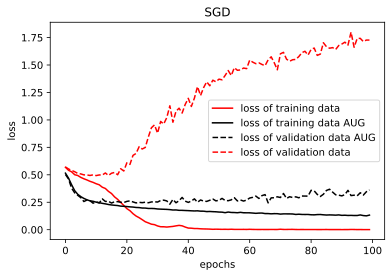

In [31]:
for obs in ('accuracy', 'loss'):
    plt.figure(figsize = (6,4))
    plt.plot(fit1.history[obs], 'r', label = obs +' of training data')
    plt.plot(fit1aug.history[obs], 'k', label = obs +' of training data AUG')
    
    plt.plot(fit1aug.history['val_' + obs], 'k--', label = obs + ' of validation data AUG')
    plt.plot(fit1.history['val_' + obs], 'r--', label = obs + ' of validation data')
    plt.title('SGD')
    plt.ylabel(obs)
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

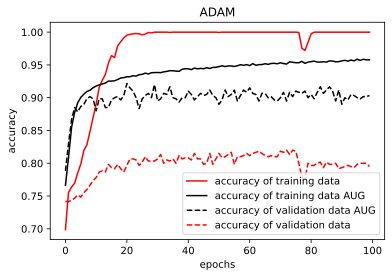

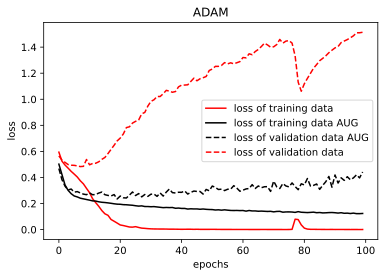

In [33]:
for obs in ('accuracy', 'loss'):
    plt.figure(figsize = (6,4))
    plt.plot(fit.history[obs], 'r', label = obs +' of training data')
    plt.plot(fitaug.history[obs], 'k', label = obs +' of training data AUG')
    
    plt.plot(fitaug.history['val_' + obs], 'k--', label = obs + ' of validation data AUG')
    plt.plot(fit.history['val_' + obs], 'r--', label = obs + ' of validation data')
    plt.title('ADAM')
    plt.ylabel(obs)
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

### Score

In [23]:
def Score_DNN(model,x_test,y_test):
    N = len(y_test)
    y_out = np.zeros(N)
    for i in range(N):
        y_out[i] = model.predict_classes(x_test[i])
    return sum(y_test) - sum(y_out)

In [24]:
print(Score_DNN(model,x_test,y_test))

C:\Users\simon\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


ValueError: in user code:

    C:\Users\simon\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\simon\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\simon\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\simon\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\simon\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\simon\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\simon\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\simon\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\simon\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected axis -1 of input shape to have value 64 but received input with shape (32, 1)
